## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [5]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [6]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [7]:
 # Calculate number of rows in dataset and display
df_length = len(df)
print(df_length)

294478


c. The number of unique users in the dataset.

In [8]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [9]:
(df.converted==1).mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [10]:
len(df[(df['landing_page']=='new_page' )& (df['group']=='control')]) + len(df[(df['landing_page']=='old_page' )& (df['group']=='treatment')])

3893

f. Do any of the rows have missing values?

In [11]:
df.isnull().any()

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [29]:
# 'treatment' and 'new_page' matched dataframe
df_a = df[(df['group']=='treatment') & (df['landing_page']!='old_page')]
df_a.shape

(145311, 5)

In [30]:
#'control' and 'old_page'matched dataframe
df_b = df[(df['group']=='control') & (df['landing_page']!='new_page')]
df_b.shape

(145274, 5)

In [31]:
# combine two dataframe
df2 = df_a.append(df_b)

In [32]:
df2.shape

(290585, 5)

In [34]:
# Double Check all of the correct rows were removed - this should be 0 ??
#  df2 is the dataset which deleted the wrong matched rows
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [35]:
print("Unique users:", df2.user_id.nunique())

print("Non_unique users:", len(df2)-df2.user_id.nunique())



Unique users: 290584
Non_unique users: 1


b. There is one **user_id** repeated in **df2**.  What is it?

In [36]:
df2[df2.user_id.duplicated()==True].user_id

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [37]:
df2[df2.user_id.duplicated()==True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [38]:
# drop duplicated user
df2=df2.drop_duplicates('user_id')
df2.shape

(290584, 5)

In [39]:
# check the drop worked
df2.user_id.duplicated().any()

False

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [40]:
(df2['converted']==1).mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [42]:
p_control = (df2[df2['group']=='control']['converted']==1).mean()

print('The probabability of control gruop converted is:',p_control)

The probabability of control gruop converted is: 0.1203863045004612


c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [44]:

p_treatment=(df2[df2['group']=='treatment']['converted']==1).mean()

print('The probabability of treatment group converted is:',p_treatment)


The probabability of treatment group converted is: 0.11880806551510564


In [45]:
p_diff = p_treatment - p_control

print('The convert difference between control and treatment is:',p_diff)

The convert difference between control and treatment is: -0.0015782389853555567


d. What is the probability that an individual received the new page?

In [47]:
(df['landing_page']=='new_page').mean()

0.5

e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?  Write your response below.

On the condition of the almost same amount of control group and treatment group, the control group with old page converted at a higher rate than the treatment group with new page. However the difference of conversion rate between two group is very small, less than 0.2%



<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.



Null-hypothesis: 
    H0 : P𝑛𝑒𝑤-  P𝑜𝑙𝑑 <=0
    
Alternative-hypothesis:
     Hy : P𝑛𝑒𝑤-  P𝑜𝑙𝑑 > 0
    

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [48]:
# Calculate probability of convert for new page
p_new=(df2[df2['landing_page']=='new_page']['converted']==1).mean()
print('p_new:', p_new)

p_new: 0.11880806551510564


In [49]:
# Calculate probability of convert for old page
p_old=(df2[df2['landing_page']=='old_page']['converted']==1).mean()
print('p_old:', p_old)

p_old: 0.1203863045004612


In [50]:
# Take the mean of these two probabilities
p_mean =np.mean([p_new,p_old])
print('Probability of conversion under null hypothesis(p_mean):',p_mean)

Probability of conversion under null hypothesis(p_mean): 0.11959718500778342


In [51]:
# Calculate differences in probability of conversion for new and old page
p_diff= p_new-p_old
print('Difference in probability of conversion for new and old page:',p_diff)

Difference in probability of conversion for new and old page: -0.0015782389853555567


In [53]:
# convert rate for 𝑝_𝑛𝑒𝑤  under the null
p_new = p_mean

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [54]:
p_old=p_mean

c. What is $n_{new}$?

In [55]:
N_new = len(df2[df2['landing_page']=='new_page'])
N_old = len(df2[df2['landing_page']=='old_page'])

In [56]:
print('New_page is:',N_new)

New_page is: 145310


d. What is $n_{old}$?

In [57]:
print('Old_page is:',N_old)

Old_page is: 145274


e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [59]:
p_new_converted=np.random.choice([1, 0],size=N_new,p=[p_mean,(1-p_mean)])
p_new_converted.mean()

0.12011561489229922

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [60]:
p_old_converted=np.random.choice([1,0],size=N_old,p=[p_mean,(1-p_mean)])
p_old_converted.mean()

0.1187824387020389

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [61]:
p_new_converted.mean()-p_old_converted.mean()

0.0013331761902603129

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [63]:
p_diffs=[]
for i in range(10000):
    p_new_converted = np.random.choice([1,0],size=N_new,p=[p_mean,(1-p_mean)])
    p_old_converted = np.random.choice([1,0],size=N_old,p=[p_mean,(1-p_mean)])
    p_diff_converted = p_new_converted.mean()- p_old_converted.mean()
    p_diffs.append(p_diff_converted)
    
    

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

In [64]:
low_ext= p_diff
high_ext=np.array(p_diffs).mean()

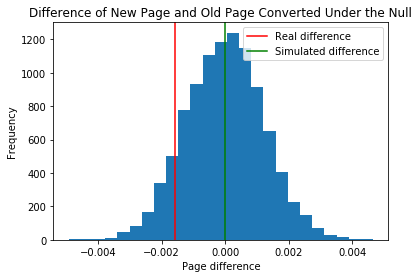

In [66]:
plt.hist(p_diffs, bins=25)
plt.title('Difference of New Page and Old Page Converted Under the Null')
plt.xlabel('Page difference')
plt.ylabel('Frequency')
plt.axvline(x=low_ext, color='r', label="Real difference")
plt.axvline(x=high_ext, color='g', label="Simulated difference")
plt.legend()
plt.show()

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [67]:
(p_diffs>low_ext).mean()

0.8982

In [123]:
# Calculate values
print('Actual difference:',p_diff)

print('Proportion greater than actual difference:', (p_diffs>low_ext).mean())


Actual difference: -0.00157823898536
Proportion greater than actual difference: 0.9044


k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?


The value we calculated is the p-value.

We found that almost 90%  of the difference population in our simulated sample greater than actual difference, from which we can conclude that the new page isn't better than the old page, it might be even worse!








l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [124]:


convert_old = len(df2[(df2['landing_page']=='old_page')&(df2['converted']==1)])
convert_new = len(df2[(df2['landing_page']=='new_page')&(df2['converted']==1)])
n_old = N_old
n_new = N_new

print('The conversion number for old page is:',convert_old)
print('The conversion number for new page is:',convert_new)
print('{} people received old page.'.format(n_old))
print('{} people received new page.'.format(n_new))

The conversion number for old page is: 17489
The conversion number for new page is: 17264
145274 people received old page.
145310 people received new page.


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [125]:
# Find z-score and p-value
import statsmodels.api as sm
z_score, p_value = sm.stats.proportions_ztest(count=[convert_new, convert_old], 
                                              nobs=[n_new, n_old])

print('z-score:',z_score, "\np-value:",p_value)

z-score: -1.31092419842 
p-value: 0.189883374482


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?


Simply put, a z-score is the number of standard deviations from the mean a data point is. But more technically it’s a measure of how many standard deviations below or above the population mean a raw score is

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?


logistic regression

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a colun for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [126]:
# add column 'intercept','ab_page'
df2['intercept'] = 1
df2[['treatment','control']] = pd.get_dummies(df2['group'])
df2['ab_page']=df2['control']
df2=df2.drop('control',axis=1)
df2=df2.drop('treatment',axis=1)


In [127]:
# Check everything  has worked
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [128]:
# Set up logistic regression
logit = sm.Logit(df2['converted'], df2[['ab_page', 'intercept']])

result=logit.fit()


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [129]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 19 Nov 2018   Pseudo R-squ.:               8.077e-06
Time:                        11:49:29   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

From the summary, the p-value associated with ab_page is 0.1899, which is a little lower than the p-value  i calculated in the Part II. The reason why the value is lower is because I added an intercept which is used to count for the basic value when without treatment for the 'group'.



f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?



There are certainly disadvantages to adding too many features into your analysis. When do you regression or categorization analysis you want to have features which have large impacts on outcome, small impacts are usually not influencial and should be left for the intercept.

I believe there's a statistic which accounts for this, some sort of corrected R² value (in linear regression at least) which will give lower outputs if "useless" features are added.

However, only one feature was chosen to determine whether a user would convert (beside the intercept) so a couple of added features wouldn't hurt. I would imagine some features like the time spent looking at page and the date the page was designed might be some interesting features to add. The longer a customer spends on a page the more they are likely to be content with it and unwilling to change, it could also be the case that really old pages will not work well and people will want an updated version.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy varaibles.** Provide the statistical output as well as a written response to answer this question.

In [130]:

# Importing data
df_countries = pd.read_csv('countries.csv')

df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [131]:
df_dummy = pd.get_dummies(data=df_countries, columns=['country'])

# Performing join
df2 = df_dummy.merge(df2, on='user_id') # df.join is depricated AFAIK

# Sorting columns
df2 = df2[['user_id', 'timestamp', 'group', 'landing_page', 
           'ab_page', 'country_CA', 'country_UK', 'country_US',
           'intercept', 'converted']]

# Fix Data Types
df2[['ab_page', 'country_CA', 'country_UK', 'country_US','intercept', 'converted']] =\
df2[['ab_page', 'country_CA', 'country_UK', 'country_US','intercept', 'converted']].astype(int)

df2.head()

,user_id,timestamp,group,landing_page,ab_page,country_CA,country_UK,country_US,intercept,converted
0,834778,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,1,0
1,928468,2017-01-23 14:44:16.387854,treatment,new_page,1,0,0,1,1,0
2,822059,2017-01-16 14:04:14.719771,treatment,new_page,1,0,1,0,1,1
3,711597,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0,1,0
4,710616,2017-01-16 13:14:44.000513,treatment,new_page,1,0,1,0,1,0


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [132]:
 # Create logit_countries object
logit_countries = sm.Logit(df2['converted'], df2[['ab_page', 'country_UK', 'country_US', 'intercept']])

# Fit
result = logit_countries.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [133]:
# Show results
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 19 Nov 2018   Pseudo R-squ.:               2.323e-05
Time:                        11:49:30   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
country_UK     0.0506      0.028      1.784      0.074      -0.005       0.106
country_US     0.0408      0.027      1.516      0.130      -0.012       0.093
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
==============================================================================
"""


Conclusions

We didn't have enough evidence to reject the null hypothesis. The new page wasn't better than old version and even worse.

The conversion rates is not associated with countries. The conversion rate in the UK is roughly the same as in the US.

i would suggest the e-commerce company not to change the old pages to the new pages.

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  This is the final project in Term 1.  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.



In [1]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0